# Deep Learning & PyTorch Lightning

This notebook revisits the classic MNIST classification task that we used to demonstrate deep learning with PyTorch, but with the aim of demonstrating the benefits of using the PyTorch Lightening framework. PyTorch Lightning extends PyTorch to provide a consistent workflow for defining, training and applying deep learning models, together with many productivity gains via automating repetetive tasks common to all deep learning models.

The two core components of PyTorch Lightning are the `LightningModule` and `Trainer` classes. This notebook makes use of these classes to rework a pure PyTorch MNIST classification model (see previous notebook on 'Deep Learning with PyTorch').

## Imports and Configuration

We can use PyTorch lightening to manage random seeds.

In [20]:
from typing import Sequence, Tuple

import torch
import torchvision
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

pl.seed_everything(42, workers=True)

Global seed set to 42


42

## Get Dataset

In [21]:
train_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

print(f'{len(train_data):,} instances of training data')
print(f'{len(test_data):,} instances of training data')

60,000 instances of training data
10,000 instances of training data


Inspect a single instance of training data.

label = 5


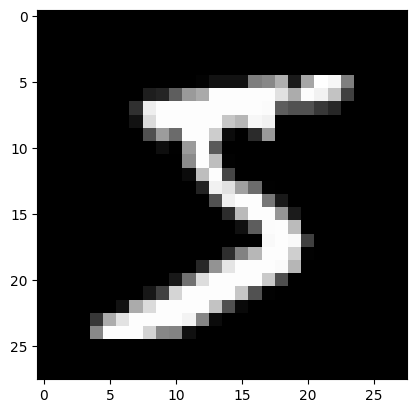

In [22]:
data_instance, data_label = train_data[0]
print(f'label = {data_label}')
_ = plt.imshow(data_instance[0], cmap='gray')

## Training a Classification Model

The `pytorch_lightning.LightningModule` inherits from `torch.nn.Module` and extends with several methods that help to standardise deep learning workflows. We will only make use of those that assist with training and prediction - for full details see the [LightningModule API reference](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

In [23]:
class ClassifyMNIST(pl.LightningModule):
    """MNIST classification with PyTorch Lightening."""
    
    def __init__(self, n_hidden_neurons):
        """Constructor.
        
        Model definition and configuration.
        """
        super().__init__()
        self.input_dim = 28 * 28
        self.n_classes = 10
        self.n_hidden_neurons = n_hidden_neurons

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_dim, n_hidden_neurons),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons, self.n_classes)
        )
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Compute a forward-pass of the model."""
        return self.model(X)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """Compute the loss for a single batch within an epoch."""
        X, y = batch
        y_hat = self.model.forward(X)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log("train_loss", loss)  # TensorBoard logging
        return loss

    def configure_optimizers(self):
        """Setup optimisers to use for training."""
        optimiser = torch.optim.SGD(self.parameters(), lr=0.05)
        return optimiser

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        """Compute test metrics for a single batch of test data."""
        X, y = batch
        y_hat_prob = self.model(X)
        y_hat_cat = torch.argmax(y_hat_prob, 1)
        accuracy = (y_hat_cat == y).sum() / len(y)
        metrics = {"accuracy": accuracy}
        self.log_dict(metrics)

    def predict_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int, dataloader_idx: int = 0) -> torch.Tensor:
        """Score a single batch of data."""
        X, y = batch
        y_hat_prob = self.model(X)
        y_hat_cat = torch.argmax(y_hat_prob, 1)
        return y_hat_cat

The `training_step` and `configure_optimizers` methods will enable the `Trainer` class to run training, without us needing to develop the training loop. Whereas these methods are mandatory, there are many methods that can be overriden that are not. We've decided to define our own `test_step` and `predict_step` methods, to enable the computation of performance metrics and inference, respectively.

We can now fit the model using the `Trainer` class, that will handles GPU acceleration, checkpointing (i.e., saving) parameters and a lot more - see the [Trainer API reference](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) for the full details.

In [24]:
model = ClassifyMNIST(28*28)
trainer = pl.Trainer(max_epochs=10, deterministic=True, default_root_dir=".", accelerator="auto")
train_data_loader = DataLoader(dataset=train_data, batch_size=500, num_workers=10)
trainer.fit(model=model, train_dataloaders=train_data_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 623 K 
-------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.493     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Asses the model on the test dataset.

In [25]:
test_data_loader = DataLoader(dataset=test_data, batch_size=10000, num_workers=10)
test_metrics = trainer.test(ckpt_path="best", dataloaders=test_data_loader)
test_metrics[0]["accuracy"]

Restoring states from the checkpoint path at ./lightning_logs/version_4/checkpoints/epoch=9-step=1200.ckpt
Loaded model weights from checkpoint at ./lightning_logs/version_4/checkpoints/epoch=9-step=1200.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.9232001304626465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


0.9232001304626465

Batch inference automation.

In [26]:
predictions = trainer.predict(ckpt_path="best", dataloaders=test_data_loader, )
predictions[0]

Restoring states from the checkpoint path at ./lightning_logs/version_4/checkpoints/epoch=9-step=1200.ckpt
Loaded model weights from checkpoint at ./lightning_logs/version_4/checkpoints/epoch=9-step=1200.ckpt


Predicting: 120it [00:00, ?it/s]

tensor([7, 2, 1,  ..., 4, 5, 6])

Scoring a single instance manually.

In [27]:
model.eval()
with torch.inference_mode():
    output_from_final_layer = model.forward(data_instance)

value, index = torch.max(output_from_final_layer, 1)
index

tensor([5])